Run the following command:

pip install -r requirements.txt

In [13]:
import re
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential,load_model
from keras.layers import Embedding,LSTM,Dense,Dropout
from sklearn.model_selection import train_test_split

In [14]:
from dotenv import load_dotenv, dotenv_values
secrets = dotenv_values(".env")

consumerKey = secrets["consumerKey"]
consumerSecret = secrets["consumerSecret"]
accessToken = secrets["accessToken"]
accessSecret = secrets["accessSecret"]

In [15]:
authenticate = tweepy.OAuthHandler(consumerKey,consumerSecret)
authenticate.set_access_token(accessToken,accessSecret)

api = tweepy.API(authenticate,wait_on_rate_limit= True)

In [17]:
mention = api.mentions_timeline()
print(mention)

for tweets in mention:
  print(str(tweets.id)+'-'+tweets.text)

[]


In [28]:
df = pd.read_csv('combined.csv')
df.head()

,Column1,Column2,Column3,Column4
0,40785,I can literally eat creamy pesto pasta topped ...,sadness,0.083
1,30822,@DamnPatriot You're a POS for rejoicing in som...,joy,0.019
2,20000,I feel like I am drowning. #depression #anxiet...,fear,0.979
3,20001,I get so nervous even thinking about talking t...,fear,0.979
4,20002,I lost my blinders .... #panic,fear,0.975


<AxesSubplot:>

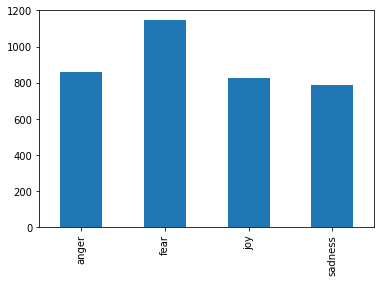

In [29]:
df['Column3'].value_counts().sort_index().plot.bar()

In [30]:
df['Column2'].apply(lambda x: x.lower())# lowercase
df['Column2'] = df['Column2'].apply(lambda x: re.sub('[@#]','',x))
df['Column2'].head()

0    I can literally eat creamy pesto pasta topped ...
1    DamnPatriot You're a POS for rejoicing in some...
2    I feel like I am drowning. depression anxiety ...
3    I get so nervous even thinking about talking t...
4                        I lost my blinders .... panic
Name: Column2, dtype: object

In [31]:
tokenizer = Tokenizer(num_words=10000,split =" ")
tokenizer.fit_on_texts(df['Column2'].values)

x = tokenizer.texts_to_sequences(df['Column2'].values)
x = pad_sequences(x)
x[:5]

x_tweet = tokenizer.texts_to_sequences(df['Column2'].values)
x_tweet = pad_sequences(x_tweet)

In [32]:
model = Sequential()
model.add(Embedding(10000,256,input_length=x.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256,return_sequences=True,dropout=0.3,recurrent_dropout=0.2))
model.add(LSTM(256,dropout=0.3,recurrent_dropout=0.2))
model.add(Dense(4,activation='softmax'))

In [33]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 256)           2560000   
_________________________________________________________________
dropout (Dropout)            (None, 33, 256)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 33, 256)           525312    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 4)                 1028      
Total params: 3,611,652
Trainable params: 3,611,652
Non-trainable params: 0
_________________________________________________________________


In [34]:
y = pd.get_dummies(df['Column3']).values 
[print(df['Column3'][i], y[i]) for i in range (0,5)]

sadness [0 0 0 1]
joy [0 0 1 0]
fear [0 1 0 0]
fear [0 1 0 0]
fear [0 1 0 0]


[None, None, None, None, None]

In [35]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state = 0)

In [81]:
model.fit(x_train, y_train,epochs=100,batch_size = 150)

Epoch 1/100
20/20 [==============================] - 19s 944ms/step - loss: 0.0260 - accuracy: 0.9869
Epoch 2/100
20/20 [==============================] - 20s 995ms/step - loss: 0.0209 - accuracy: 0.9882
Epoch 3/100
20/20 [==============================] - 21s 1s/step - loss: 0.0194 - accuracy: 0.9886
Epoch 4/100
20/20 [==============================] - 22s 1s/step - loss: 0.0188 - accuracy: 0.9900
Epoch 5/100
20/20 [==============================] - 23s 1s/step - loss: 0.0196 - accuracy: 0.9869
Epoch 6/100
20/20 [==============================] - 23s 1s/step - loss: 0.0187 - accuracy: 0.9889
Epoch 7/100
20/20 [==============================] - 24s 1s/step - loss: 0.0176 - accuracy: 0.9900
Epoch 8/100
20/20 [==============================] - 24s 1s/step - loss: 0.0172 - accuracy: 0.9889
Epoch 9/100
20/20 [==============================] - 25s 1s/step - loss: 0.0173 - accuracy: 0.9910
Epoch 10/100
20/20 [==============================] - 25s 1s/step - loss: 0.0172 - accuracy: 0.9910
Epo

In [82]:
model.save('sentiment')

INFO:tensorflow:Assets written to: sentiment\assets


In [95]:
tweets = api.mentions_timeline(tweet_mode='extended')

a = tweets[3].in_reply_to_status_id_str

tweet_a = api.get_status(id=a)
print(tweet_a.text)

zendaya and tom holland invented looking this sexy. just LOOK AT THEM https://t.co/5vkXPqRrg5


In [96]:
#create a df for the tweets
dftweet = pd.DataFrame([tweet_a.text],columns = ["Tweets"])
dftweet.head()

,Tweets
0,zendaya and tom holland invented looking this ...


In [97]:
#clean tweets
def cleanTxt(text):
  text =re.sub(r'@[A-Za-z0-9]+','',text) #remove @
  text = re.sub(r'#','',text)# remove #
  text = re.sub(r'RT[\s]+','',text)# remove RT
  text = re.sub(r'https?:\/\/\S+','',text)#remove hyperlink

  return text

dftweet["Tweets"]= dftweet["Tweets"].apply(cleanTxt)
print(dftweet)

                                              Tweets
0  zendaya and tom holland invented looking this ...


In [1]:
def check (i):
  if ( i == 0):
    return('Anger')
  elif (i == 1):
    return('Fear')
  elif (i==2):
    return('Joy')
  else:
    return('Sadness')
predictions = model.predict(x_tweet)

a = 0
index = 0
for p in range (0,4):
    print(a)
    if (predictions[i][p]>a):
      a = predictions[i][p]
      index = p
# print(dftweet["Tweets"][i],predictions[i],index)
print(check(index))

NameError: name 'model' is not defined